### DCGAN

In [1]:
import os

In [2]:
#os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
#os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
#import os
import PIL
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from IPython import display

In [4]:
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("GPU not found")

In [6]:
mnist = keras.datasets.mnist
path = '/home/barc/Desktop/subir/mnist.npz'

(train_images, train_labels), (test_images, test_labels) = mnist.load_data(path=path)

In [7]:
'''
path = 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\keras\\api\\keras\\datasets\\mnist\\mnist.npz'

def load_data(path):
    with np.load(path, allow_pickle=True) as f:
        #disable=unexpected-keyword-arg
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']

    return (x_train, y_train), (x_test, y_test)
'''

"\npath = 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\keras\\api\\keras\\datasets\\mnist\\mnist.npz'\n\ndef load_data(path):\n    with np.load(path, allow_pickle=True) as f:\n        #disable=unexpected-keyword-arg\n        x_train, y_train = f['x_train'], f['y_train']\n        x_test, y_test = f['x_test'], f['y_test']\n\n    return (x_train, y_train), (x_test, y_test)\n"

In [8]:
#(train_images, train_labels), (test_images, test_labels) = load_data(path=path)

In [9]:
train_images.shape

(60000, 28, 28)

1


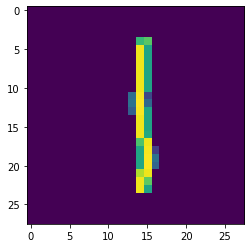

In [10]:
i = 1002
print(train_labels[i])
plt.imshow(train_images[i])

In [11]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

9


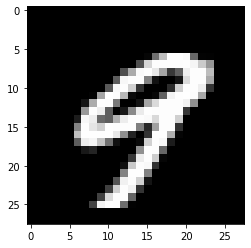

In [12]:
i = 1005
print(train_labels[i])
plt.imshow(train_images[i], cmap='gray')

In [13]:
train_images.shape

(60000, 28, 28, 1)

In [14]:
BUFFER_SIZE = 60000
BATCH_SIZE = 512

In [15]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2022-05-31 17:33:05.612744: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-31 17:33:06.028139: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21493 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6


In [16]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [17]:
#sess = tf.InteractiveSession()

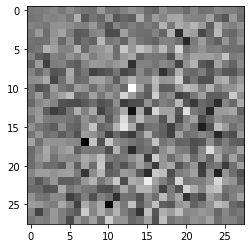

In [19]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, 0:, :, 0], cmap='gray')

In [20]:
noise.shape

TensorShape([1, 100])

In [21]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

In [22]:
generated_image[0, :, :, 0].shape

TensorShape([28, 28])

In [23]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [24]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00038647]], shape=(1, 1), dtype=float32)


In [25]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
a = cross_entropy([0, 1], [1.2, -40])

In [27]:
a

<tf.Tensor: shape=(), dtype=float32, numpy=20.731642>

In [28]:
a.numpy()

20.731642

In [29]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [30]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [32]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [33]:
EPOCHS = 1
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [39]:
d_losses, g_losses = [], []

In [48]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    
    i = 0
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        
        print("i: ", i)
        tf.print(gen_loss)
        i+=1
        #print(disc_loss)
        #g_losses.append(gen_loss.numpy())
        #d_losses.append(disc_loss.numpy())

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [49]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        #display.clear_output(wait=True)
        #generate_and_save_images(generator,
        #                     epoch + 1,
        #                     seed)

        # Save the model every 3 epochs
        #if (epoch + 1) % 3 == 0:
            #checkpoint.save(file_prefix = checkpoint_prefix)

        #print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

      # Generate after the final epoch
      #display.clear_output(wait=True)
      #generate_and_save_images(generator,
      #                     epochs,
      #                     seed)

In [50]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    #for i in range(predictions.shape[0]):
        #plt.subplot(4, 4, i+1)
        #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        #plt.axis('off')

    #plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    #plt.show()

In [51]:
train(train_dataset, EPOCHS)

i:  0
0.806278706
0.781398594
0.7689569
0.780080199
0.778409064
0.781741917
0.782178
0.763737917
0.775447845
0.756317139
0.732839584
0.711565256
0.717678905
0.676910043
0.676396847
0.667510152
0.670796931
0.663885295
0.671550035
0.672551751
0.676884532
0.687114716
0.691658139
0.704428732
0.711594343
0.723391116
0.749991417
0.742725968
0.761488795
0.772460282
0.788625598
0.79950583
0.804846346
0.8110708
0.822085142
0.828458488
0.840459585
0.850509048
0.852749586
0.847294569
0.85722667
0.84784615
0.850603402
0.835298181
0.833057642
0.816637933
0.819112122
0.822135
0.823540866
0.804859877
0.798058569
0.782738924
0.765732
0.754078567
0.736127079
0.705417275
0.696766257
0.674390554
0.670513928
0.649501681
0.636187196
0.628503323
0.618465424
0.614811242
0.596225441
0.606812
0.613596261
0.611568928
0.614835501
0.624845207
0.639940858
0.648826241
0.659310043
0.668429911
0.69097352
0.709156871
0.734546304
0.770071268
0.789205074
0.821903646
0.834104955
0.8495332
0.864505887
0.86626476
0.8882793

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('images/image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('images/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)